In [1]:
import jax
jax.config.update('jax_enable_x64', True)
jax.config.update('jax_platform_name', 'cpu')
from qiskit_dynamics.array import Array
Array.set_default_backend('jax')

In [2]:
import numpy as np

dim = 3

v0 = 4.86e9
anharm0 = -0.32e9
r0 = 0.22e9

v1 = 4.97e9
anharm1 = -0.32e9
r1 = 0.26e9

J = 0.002e9

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
N = np.diag(np.arange(dim))

ident = np.eye(dim, dtype=complex)
full_ident = np.eye(dim**2, dtype=complex)

N0 = np.kron(ident, N)
N1 = np.kron(N, ident)

a0 = np.kron(ident, a)
a1 = np.kron(a, ident)

a0dag = np.kron(ident, adag)
a1dag = np.kron(adag, ident)

static_ham0 = 2. * np.pi * v0 * N0 + np.pi * anharm0 * N0 * (N0 - full_ident)
static_ham1 = 2. * np.pi * v1 * N1 + np.pi * anharm1 * N1 * (N1 - full_ident)

static_ham_full = static_ham0 + static_ham1 + 2. * np.pi * J * ((a0 + a0dag) @ (a1 + a1dag))

drive_op0 = 2. * np.pi * r0 * (a0 + a0dag)
drive_op1 = 2. * np.pi * r1 * (a1 + a1dag)

In [3]:
from qiskit_dynamics import Solver

dt = 1/4.5e9

solver = Solver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1],
    rotating_frame=static_ham_full,
    hamiltonian_channels=["d0", "d1", "u0", "u1"],
    channel_carrier_freqs={"d0": v0, "d1": v1, "u0": v1, "u1": v0},
    dt=dt
)

In [4]:
from qiskit_dynamics import DynamicsBackend

# Consistent Solver Options
solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax": dt}

backend = DynamicsBackend(
    solver=solver,
    subsystem_dims=[dim, dim], # For Computing Measurement Data
    solver_options=solver_options, # Used every time .run() is called
)

In [5]:
from qiskit import pulse

In [6]:
sigma = 128
num_samples = 256

schedules = []

for amp in np.linspace(0., 1., 10):
    gauss = pulse.library.Gaussian(
        num_samples, amp, sigma, name="Parametric Gauss"
    )

    with pulse.build() as schedule:
        with pulse.align_sequential():
            pulse.play(gauss, pulse.DriveChannel(0))
            pulse.shift_phase(0.5, pulse.DriveChannel(0))
            pulse.shift_frequency(0.1, pulse.DriveChannel(0))
            pulse.play(gauss, pulse.DriveChannel(0))
            pulse.acquire(duration=1, qubit_or_channel=0, register=pulse.MemorySlot(0))
    schedules.append(schedule)

In [7]:
%%time

job = backend.run(schedules, shots=100)

CPU times: user 2.23 s, sys: 93.4 ms, total: 2.33 s
Wall time: 2.4 s


In [8]:
result = job.result()

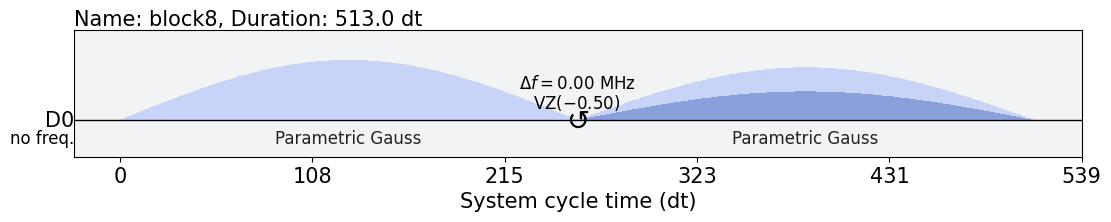

In [9]:
schedules[3].draw()

In [10]:
result.get_counts(3)

{'0': 39, '1': 61}

Simulating Circuits

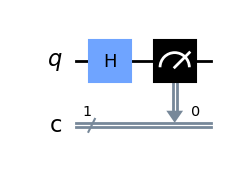

In [11]:
from qiskit import QuantumCircuit

circ = QuantumCircuit(1, 1)
circ.h(0)
circ.measure([0], [0])

circ.draw('mpl')

In [12]:
with pulse.build() as h_q0:
    pulse.play(
        pulse.library.Gaussian(duration=256, amp=0.2, sigma=50, name="custom"),
        pulse.DriveChannel(0)
    )

circ.add_calibration("h", qubits=[0], schedule=h_q0)

In [13]:
%time res = backend.run(circ).result()

res.get_counts(0)

CPU times: user 1.22 s, sys: 94 ms, total: 1.31 s
Wall time: 1.43 s


{'0': 793, '1': 231}

In [14]:
from qiskit.circuit.library import HGate
from qiskit.transpiler import InstructionProperties

backend.target.add_instruction(HGate(), {(0,): InstructionProperties(calibration=h_q0)})

In [15]:
circ2 = QuantumCircuit(1, 1)
circ2.h(0)
circ2.measure([0], [0])

%time result = backend.run(circ2).result()

CPU times: user 1.29 s, sys: 35.3 ms, total: 1.32 s
Wall time: 1.47 s


In [16]:
result.get_counts(0)

{'0': 790, '1': 234}

In [17]:
from qiskit.circuit.library import XGate, SXGate, RZGate, CXGate
from qiskit.circuit import Parameter
from qiskit.providers.backend import QubitProperties

target = backend.target

# qubit properties
target.qubit_properties = [QubitProperties(frequency=v0), QubitProperties(frequency=v1)]

# add instructions
target.add_instruction(XGate(), properties={(0,): None, (1,): None})
target.add_instruction(SXGate(), properties={(0,): None, (1,): None})

target.add_instruction(CXGate(), properties={(0, 1): None, (1, 0): None})

# Add RZ instruction as phase shift for drag cal
phi = Parameter("phi")
with pulse.build() as rz0:
    pulse.shift_phase(phi, pulse.DriveChannel(0))
    pulse.shift_phase(phi, pulse.ControlChannel(1))

with pulse.build() as rz1:
    pulse.shift_phase(phi, pulse.DriveChannel(1))
    pulse.shift_phase(phi, pulse.ControlChannel(0))

target.add_instruction(
    RZGate(phi), 
    {(0,): InstructionProperties(calibration=rz0), (1,): InstructionProperties(calibration=rz1)}
)

In [20]:
import pandas as pd
from qiskit_experiments.calibration_management.calibrations import Calibrations
from qiskit_experiments.calibration_management.basis_gate_library import FixedFrequencyTransmon

cals = Calibrations(libraries=[FixedFrequencyTransmon(basis_gates=['x', 'sx'])])

pd.DataFrame(**cals.parameters_table(qubit_list=[0, ()]))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,β,(),sx,0.00,default,True,2023-06-21 21:20:43.415377+0800,None
1,β,(),x,0.00,default,True,2023-06-21 21:20:43.415355+0800,None
2,duration,(),sx,160.00,default,True,2023-06-21 21:20:43.415388+0800,None
3,duration,(),x,160.00,default,True,2023-06-21 21:20:43.415344+0800,None
4,amp,(),sx,0.25,default,True,2023-06-21 21:20:43.415398+0800,None
5,σ,(),sx,40.00,default,True,2023-06-21 21:20:43.415366+0800,None
6,amp,(),x,0.50,default,True,2023-06-21 21:20:43.415330+0800,None
7,σ,(),x,40.00,default,True,2023-06-21 21:20:43.415288+0800,None


In [21]:
from qiskit_experiments.library.calibration import RoughXSXAmplitudeCal

# rabi experiments for qubit 0
rabi0 = RoughXSXAmplitudeCal(0, cals, backend=backend, amplitudes=np.linspace(-0.2, 0.2, 27))

# rabi experiments for qubit 1
rabi1 = RoughXSXAmplitudeCal(1, cals, backend=backend, amplitudes=np.linspace(-0.2, 0.2, 27))

In [22]:
%%time
rabi0_data = rabi0.run().block_for_results()
rabi1_data = rabi1.run().block_for_results()

CPU times: user 9.01 s, sys: 749 ms, total: 9.76 s
Wall time: 8.78 s


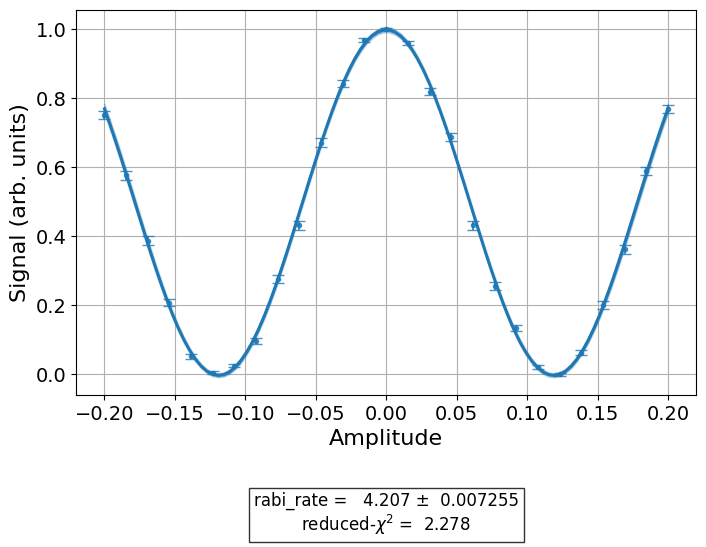

In [24]:
rabi0_data.figure(0)

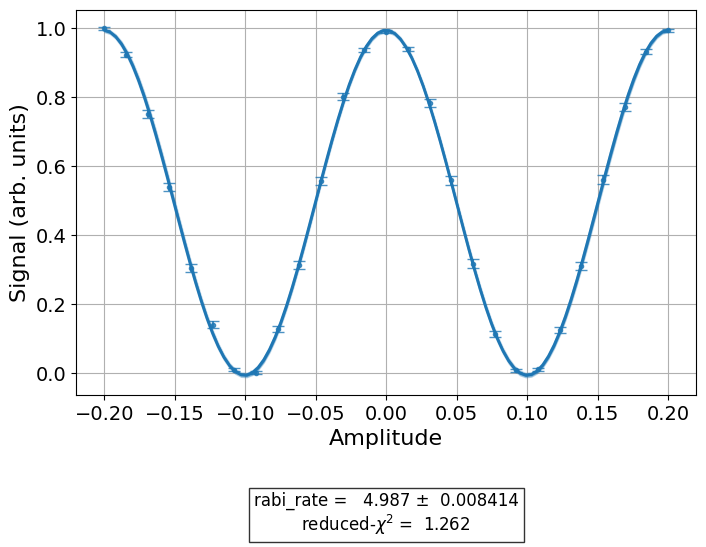

In [25]:
rabi1_data.figure(0)

In [27]:
# pd.DataFrame(**cals.parameters_table(qubit_list=[0, ()], parameters="amp"))
pd.DataFrame(**cals.parameters_table(qubit_list=[0, ()]))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,β,(),sx,0.000000+0.000000j,default,True,2023-06-21 21:20:43.415377+0800,None
1,β,(),x,0.000000+0.000000j,default,True,2023-06-21 21:20:43.415355+0800,None
2,amp,"(0,)",x,0.118857+0.000000j,default,True,2023-06-21 21:24:33.843453+0800,a16faace-b5ac-479c-8423-4ad1b0866fc9
3,duration,(),sx,160.00000+0.00000j,default,True,2023-06-21 21:20:43.415388+0800,None
4,amp,"(0,)",sx,0.059428+0.000000j,default,True,2023-06-21 21:24:33.843453+0800,a16faace-b5ac-479c-8423-4ad1b0866fc9
5,duration,(),x,160.00000+0.00000j,default,True,2023-06-21 21:20:43.415344+0800,None
6,amp,(),sx,0.250000+0.000000j,default,True,2023-06-21 21:20:43.415398+0800,None
7,σ,(),sx,40.00000+0.00000j,default,True,2023-06-21 21:20:43.415366+0800,None
8,amp,(),x,0.500000+0.000000j,default,True,2023-06-21 21:20:43.415330+0800,None
9,σ,(),x,40.00000+0.00000j,default,True,2023-06-21 21:20:43.415288+0800,None


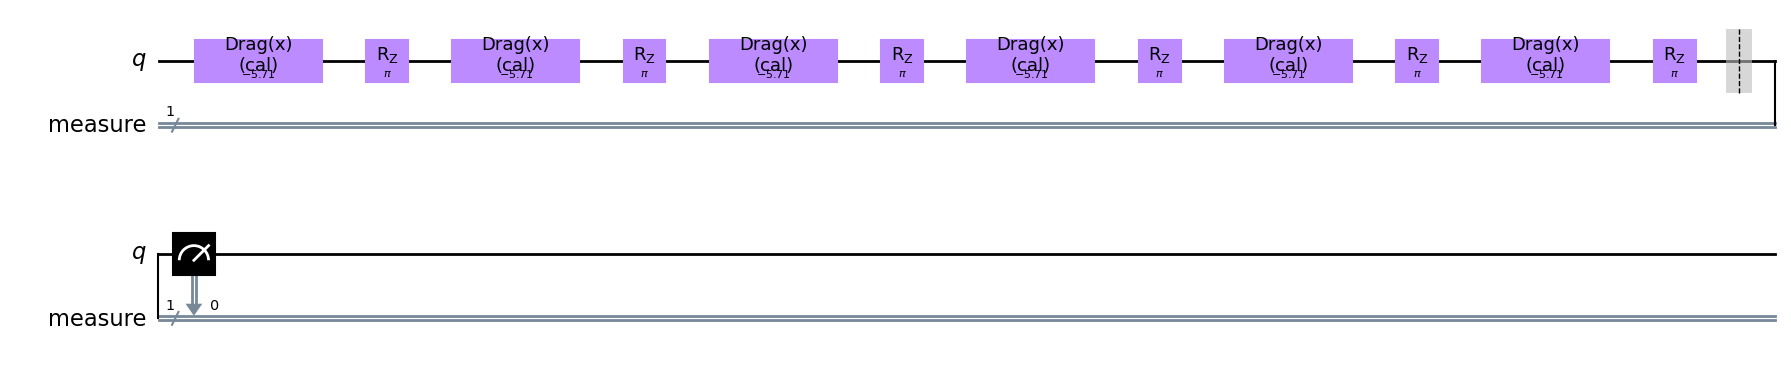

In [28]:
from qiskit_experiments.library.calibration import RoughDragCal

cal_drag0 = RoughDragCal(0, cals, backend=backend, betas=np.linspace(-20, 20, 15))
cal_drag1 = RoughDragCal(1, cals, backend=backend, betas=np.linspace(-20, 20, 15))

cal_drag0.set_experiment_options(reps=[3, 5, 7])
cal_drag1.set_experiment_options(reps=[3, 5, 7])

cal_drag0.circuits()[5].draw(output="mpl")

In [29]:
%%time
drag0_data = cal_drag0.run().block_for_results()
drag1_data = cal_drag1.run().block_for_results()

CPU times: user 33.1 s, sys: 6.2 s, total: 39.3 s
Wall time: 23.3 s


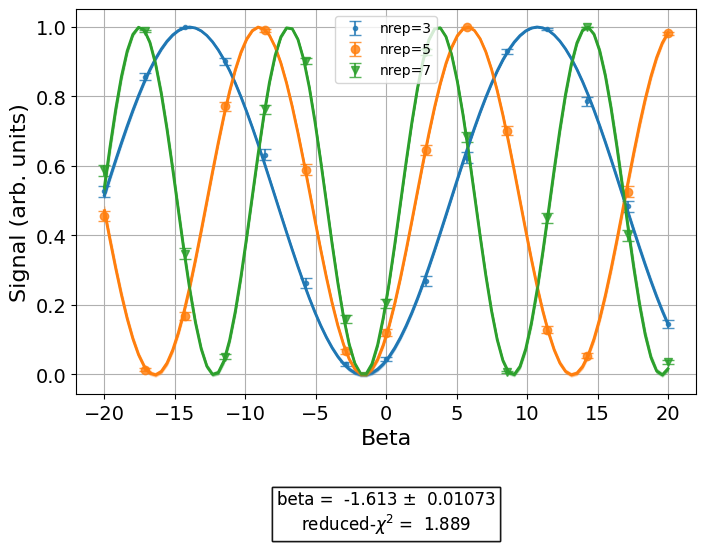

In [30]:
drag0_data.figure(0)

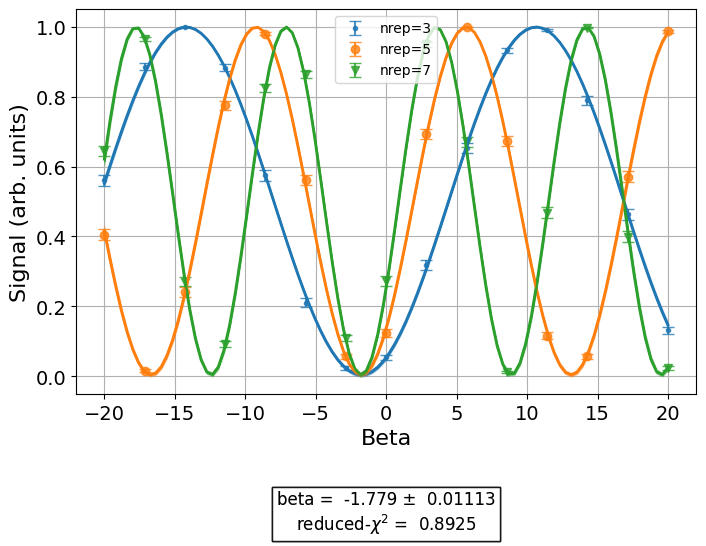

In [31]:
drag1_data.figure(0)

In [35]:
# pd.DataFrame(**cals.parameters_table(qubit_list=[0, ()], parameters="amp"))
pd.DataFrame(**cals.parameters_table(qubit_list=[0, ()]))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,β,(),sx,0.000000+0.000000j,default,True,2023-06-21 21:20:43.415377+0800,None
1,β,(),x,0.000000+0.000000j,default,True,2023-06-21 21:20:43.415355+0800,None
2,amp,"(0,)",x,0.118857+0.000000j,default,True,2023-06-21 21:24:33.843453+0800,a16faace-b5ac-479c-8423-4ad1b0866fc9
3,β,"(0,)",x,-1.613059+0.000000j,default,True,2023-06-21 21:29:35.695060+0800,170ca99a-a0aa-44a9-9ffa-0e5bee1c6160
4,duration,(),sx,160.00000+0.00000j,default,True,2023-06-21 21:20:43.415388+0800,None
5,amp,"(0,)",sx,0.059428+0.000000j,default,True,2023-06-21 21:24:33.843453+0800,a16faace-b5ac-479c-8423-4ad1b0866fc9
6,duration,(),x,160.00000+0.00000j,default,True,2023-06-21 21:20:43.415344+0800,None
7,amp,(),sx,0.250000+0.000000j,default,True,2023-06-21 21:20:43.415398+0800,None
8,σ,(),sx,40.00000+0.00000j,default,True,2023-06-21 21:20:43.415366+0800,None
9,amp,(),x,0.500000+0.000000j,default,True,2023-06-21 21:20:43.415330+0800,None


# CrossResonance Gates

In [36]:
# set the control channel map
backend.set_options(control_channel_map={(0, 1): 0, (1, 0): 1})

In [38]:
from qiskit_experiments.library import CrossResonanceHamiltonian

cr_ham_experiment = CrossResonanceHamiltonian(
    physical_qubits=(0, 1),
    flat_top_widths=np.linspace(0, 5000, 17),
    backend=backend
)

backend.target.update_from_instruction_schedule_map(cals.get_inst_map())

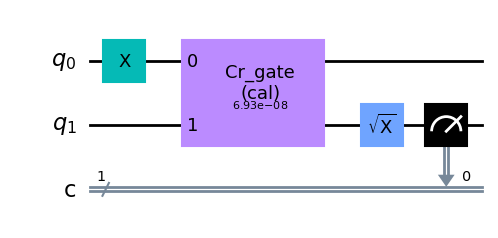

In [39]:
cr_ham_experiment.circuits()[10].draw("mpl")

In [40]:
%time data_cr = cr_ham_experiment.run().block_for_results()

CPU times: user 33.5 s, sys: 3.05 s, total: 36.6 s
Wall time: 29.2 s


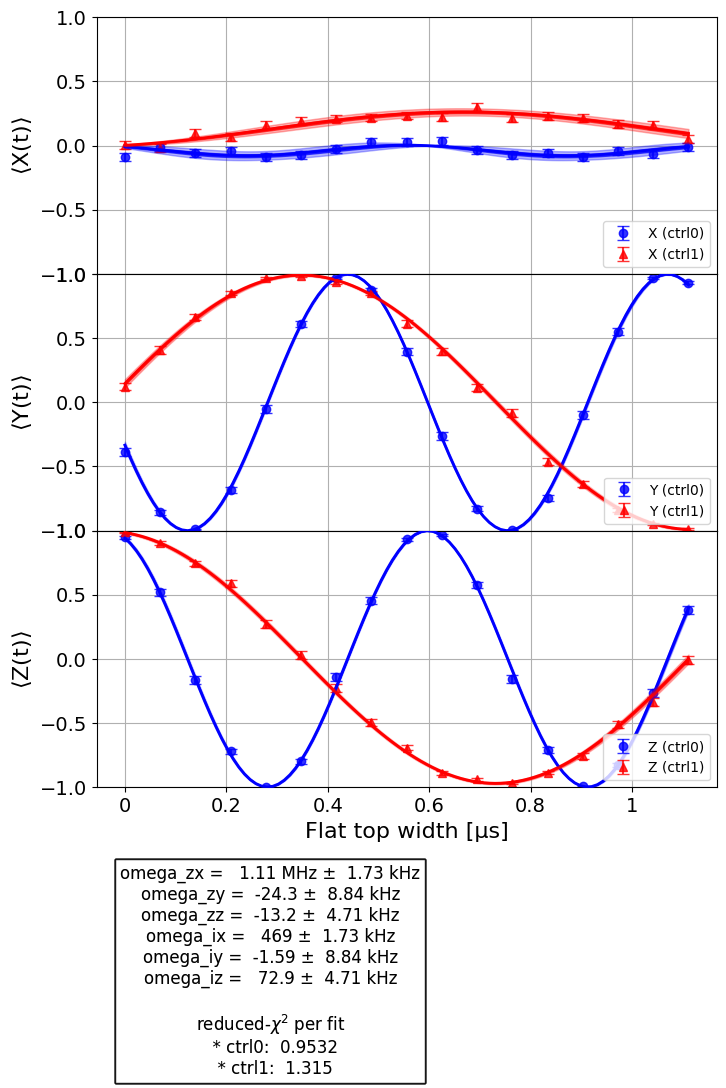

In [41]:
data_cr.figure(0)